## Problem Statement:
### To analyze the best restaurants in major cities from a restaurant dataset collected from Zomato

### ------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymongo import MongoClient

#### Functions for Mongo connection and retrieval of data in dataframe

In [41]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

#### Getting data from mongodb in a dataframe

In [42]:
df = read_mongo('restaurants', 'zomato_all')
df_CC = read_mongo('restaurants', 'country_codes')

In [43]:
df.rename(columns = {'Country Code': 'Country_code', 'Aggregate rating':'Aggregate_rating', 'Has Table booking': 'Has_table_booking', 'Has Online delivery': 'Has_online_delivery', 'Is delivering now':'Is_delivering_now', 
                          'Switch to order menu' : 'Switch_to_order_menu', 'Average Cost for two' : 'Average_cost_for_two', 'Price range' : 'Price_range', 'Rating color' : 'Rating_color', 'Rating text' : 'Rating_text', 'Restaurant ID':'Restaurant_ID', 'Restaurant Name':'Restaurant_name', 'Locality Verbose':'Locality_verbose'}, inplace = True)

In [44]:
df = df[['Restaurant_ID', 'Restaurant_name', 'Country_code', 'City', 'Address', 'Locality', 'Locality_verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average_cost_for_two', 'Currency', 'Has_table_booking', 'Has_online_delivery', 'Is_delivering_now', 'Switch_to_order_menu', 'Price_range', 'Aggregate_rating', 'Rating_color', 'Rating_text', 'Votes']]

#### Assigning numeric values for each "Rating_text"

In [45]:
df['Rating_category'] = df['Rating_text'].map({ 'Not Rated':-1 , 'Poor':0, 'Average':2, 'Good':3, 'Very Good':4, 'Excellent':5})

#### Pie plot visualization for the country for which the dataset contains the maximum number of entries:

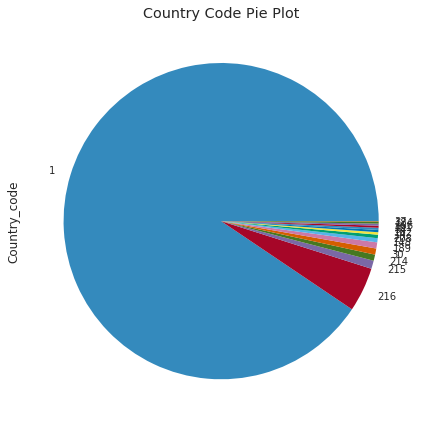

In [46]:
with plt.style.context(('bmh')):
    plt.figure(figsize = (24,16))  # Keep 3:2
    ax = plt.subplot2grid((2,3), (0,0))
    cnt = df['Country_code'].value_counts()
    cnt.plot.pie(ax = ax)
    ax.set_title('Country Code Pie Plot')

#### Country with code = 1 has the majority.
#### The currency for this country is:

In [47]:
# The dataframe df1 involves only Indian restaurants
df1 = df.loc[df['Country_code'] == 1]
currency_cc1 = df1['Currency'].unique()
currency_cc1[0]

'Indian Rupees(Rs.)'

#### The barplot below confirms the same.

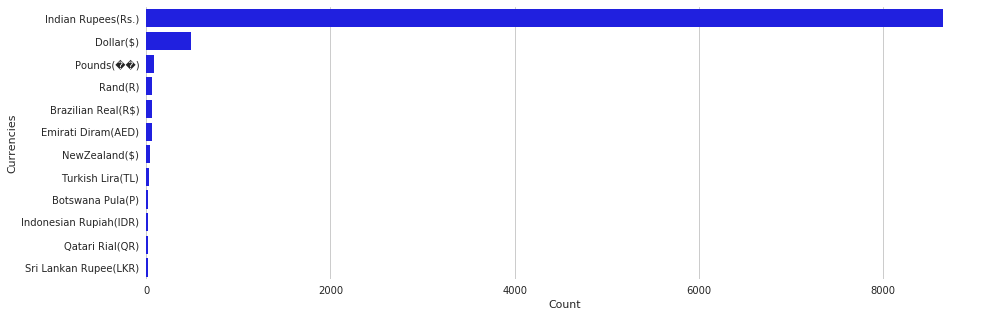

In [48]:
f, ax = plt.subplots(1,1,figsize = (15,5))
df_currency_count = df['Currency'].value_counts().reset_index()
df_currency_count.rename( columns = { 'index':'Currencies', 'Currency': 'Count' } , inplace = True)
# Returns a dataframe in "cnt" variable

sns.set(style="whitegrid")
sns.barplot(y = 'Currencies', x = 'Count', data = df_currency_count, color = 'b', ax = ax)
sns.despine(left=True, bottom=True)
plt.show()

#### To find the major cities for which restaurant data is available from the Indian Restaurant Dataframe "df1"

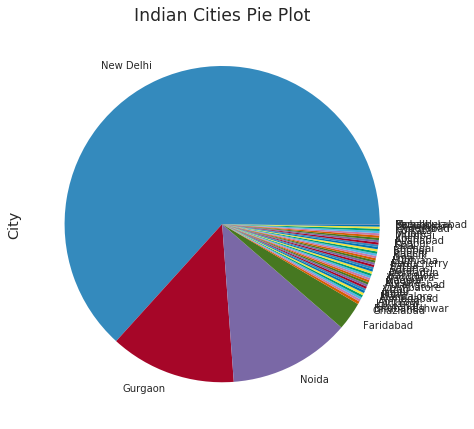

In [49]:
with plt.style.context(('bmh')):
    plt.figure(figsize = (24,16))  # Keep 3:2
    ax = plt.subplot2grid((2,3), (0,0))
    cnt = df1['City'].value_counts()
    cnt.plot.pie(ax = ax)
    ax.set_title('Indian Cities Pie Plot')

In [50]:
df1['City'].value_counts().head()

New Delhi    5473
Gurgaon      1118
Noida        1080
Faridabad     251
Ghaziabad      25
Name: City, dtype: int64

#### Here, New Delhi is dominating with 5473 restaurants listed.
#### Gurgaon and Noida are the next 2 notable cities with around 1000 restaurants listed.
#### Since, the data is hugely focused on New Delhi, we consider analyzing the restaurants in New Delhi only.


 

### ------------------------------------- New Delhi only ----------------------------------------

In [51]:
df1_nd = df1.loc[df1['City'] == 'New Delhi']

#df1_nd ---> dataframe for New Delhi

#### Frequency barplot for Rating_text

In [52]:
df1_nd.Rating_text.unique()

array(['Not rated', 'Average', 'Good', 'Poor', 'Very Good', 'Excellent'], dtype=object)

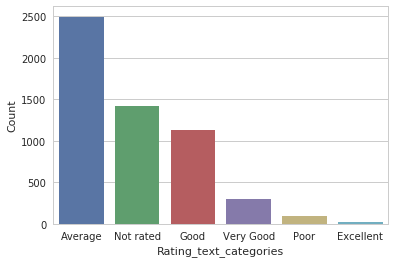

In [53]:
df1_nd_rating_text_count = df1_nd['Rating_text'].value_counts().reset_index()
df1_nd_rating_text_count.rename( columns = {'index':'Rating_text_categories', 'Rating_text' : 'Count'}, inplace = True)
sns.set_style("whitegrid")
sns.barplot(x="Rating_text_categories", y="Count", data=df1_nd_rating_text_count)

In [54]:
df1_nd_rating_text_count

,Rating_text_categories,Count
0,Average,2495
1,Not rated,1425
2,Good,1128
3,Very Good,300
4,Poor,97
5,Excellent,28


In [55]:
df1_nd_notrated = df1_nd.loc[df1_nd['Rating_text'] == 'Not rated']
df1_nd_notrated['Votes'].value_counts()

0    715
1    329
2    222
3    159
Name: Votes, dtype: int64

#### All the 1425 restaurants which are "Not rated" have only 0 to 3 people voting for them.
#### Hence, their rating has been ignored.
#### We thus ignore the same restaurants as predicting their rating would not be very accurate

In [56]:
df1_nd = df1_nd.loc[df1['Rating_text'] != 'Not rated']

In [57]:
df1_nd.Rating_text.unique()

array(['Average', 'Good', 'Poor', 'Very Good', 'Excellent'], dtype=object)

In [58]:
df1_nd['Restaurant_ID'].count()

4048

In [59]:
df1_nd['Restaurant_name'].value_counts().count()

3094

#### Therefore, after removing the "Not rated" restaurants, our "df1_nd" dataframe contains 4048 restaurants.
#### Out of these 4048, number of unique restaurants = 3094

#### ------------------------------------------------------------------------------------------------------------------------------------
#### It is important to note that a combined score of "Aggregate_rating" and "Votes" is required to understand the rating of a restaurant

In [60]:
df1_nd['Combined_rating'] = df1_nd.Aggregate_rating * df1_nd.Votes

In [61]:
df1_nd.head(2)

,Restaurant_ID,Restaurant_name,Country_code,City,Address,Locality,Locality_verbose,Longitude,Latitude,Cuisines,...,Has_online_delivery,Is_delivering_now,Switch_to_order_menu,Price_range,Aggregate_rating,Rating_color,Rating_text,Votes,Rating_category,Combined_rating
2559,18216944,Burger.in,1,New Delhi,"84, Near Honda Showroom, Adchini, New Delhi",Adchini,"Adchini, New Delhi",77.196923,28.535382,Fast Food,...,Yes,No,No,1,3.2,Orange,Average,46,2.0,147.2
2562,313333,Days of the Raj,1,New Delhi,"81/3, 1st Floor, Qutub Residency, Adchini, New...",Adchini,"Adchini, New Delhi",77.197475,28.535493,"North Indian, Seafood, Continental",...,Yes,No,No,3,3.4,Orange,Average,45,2.0,153.0


### ---------------------------------------------- New Delhi only ---------------------------------------------------------------------------

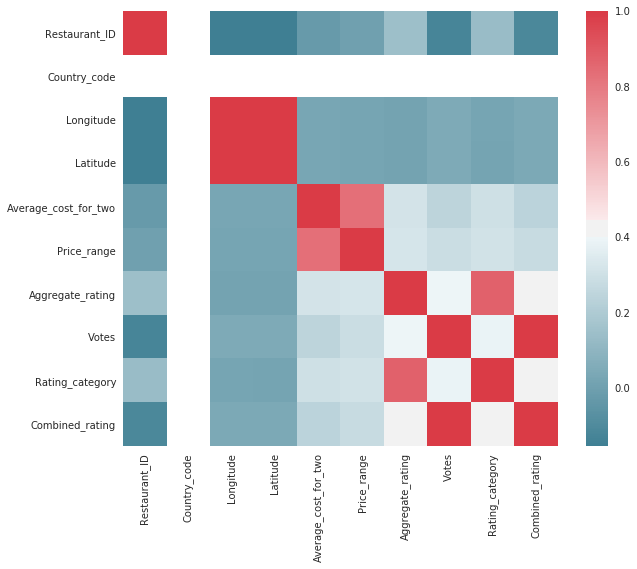

In [65]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df1_nd.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

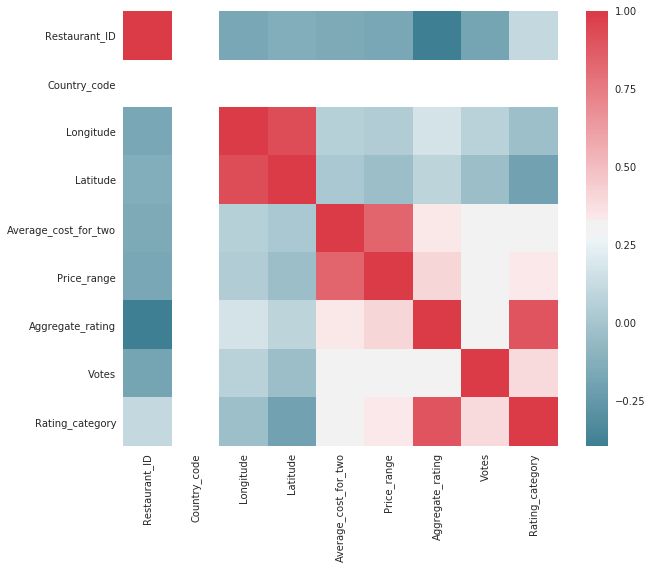

In [63]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

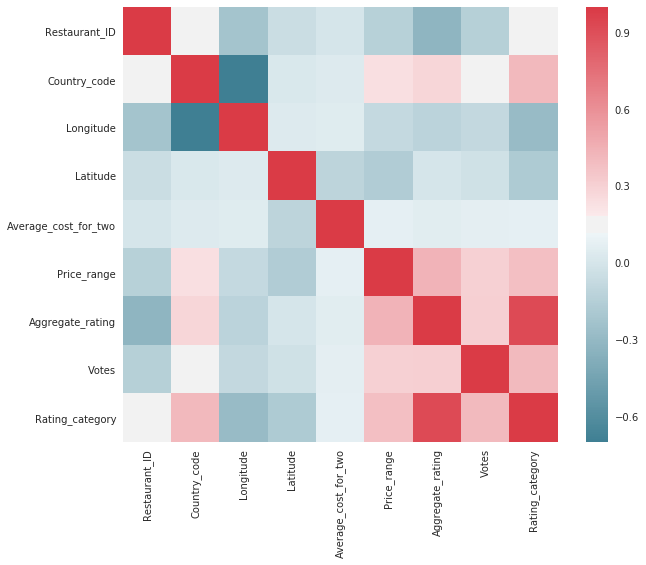

In [64]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)